In [31]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)

# from utils.helper import fn_plot_confusion_matrix

In [32]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [33]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 32 # batch size for training   
TRAIN_SIZE = BATCH_SIZE * 9
WEIGHT_DECAY = 0.001

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [34]:
data_df = pd.read_csv('ionosphere.data', header=None)

In [35]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()
y = data_df[data_df.columns[-1]].to_numpy()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= TRAIN_SIZE, 
                                                    stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [37]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [38]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [39]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [40]:
## Some Model Specification
rate1 = 0.05
rate2 = 0.15
rate3 = 0.25

initalizer = tf.keras.initializers.GlorotUniform(seed= RANDOM_STATE)
optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA, weight_decay=WEIGHT_DECAY)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape = (34,)),
    # set 1
    tf.keras.layers.Dense(26, kernel_initializer= initalizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    tf.keras.layers.Dropout(rate1, seed=RANDOM_STATE),
    
    # set 2
    tf.keras.layers.Dense(18, kernel_initializer= initalizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    tf.keras.layers.Dropout(rate2, seed=RANDOM_STATE),
    
    # set 3
    tf.keras.layers.Dense(10, kernel_initializer= initalizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation='relu'),
    tf.keras.layers.Dropout(rate3, seed=RANDOM_STATE),

    # output layer
    tf.keras.layers.Dense(2)
])

model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics = ['accuracy'])

In [41]:
chkpt_filepath = f'{altName}.weights.h5'

In [42]:
EPOCHS = 500
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

model_chkpt = tf.keras.callbacks.ModelCheckpoint(
    chkpt_filepath,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    restore_best_weights=True
)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    min_lr=1e-5
)

In [43]:
# # Step 1 :  Loss function
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # Step 2 : Optimizer
# #ALPHA=0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# # Step 3 :
# model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model.fit(X_train, y_train,callbacks = [model_chkpt, escb, lrcb], 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/500
1/9 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8438 - loss: 0.5054
Epoch 1: val_loss improved from inf to 0.64582, saving model to all_in.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7177 - loss: 0.6536 - val_accuracy: 0.7619 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 2/500
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6875 - loss: 0.8521
Epoch 2: val_loss improved from 0.64582 to 0.61076, saving model to all_in.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6868 - loss: 0.6705 - val_accuracy: 0.8095 - val_loss: 0.6108 - learning_rate: 0.0010
Epoch 3/500
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6562 - loss: 0.6489
Epoch 3: val_loss improved from 0.61076 to 0.57386, saving model to all_in.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7096 - loss: 0.6147 - val_accuracy: 0.8413 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 4/500
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8438 - loss: 0.4976

In [44]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.701389,0.693935,0.761905,0.645820,0.001
1,0.684028,0.644299,0.809524,0.610759,0.001
2,0.711806,0.612167,0.841270,0.573857,0.001
3,0.788194,0.557585,0.857143,0.541886,0.001
4,0.798611,0.519912,0.873016,0.510116,0.001


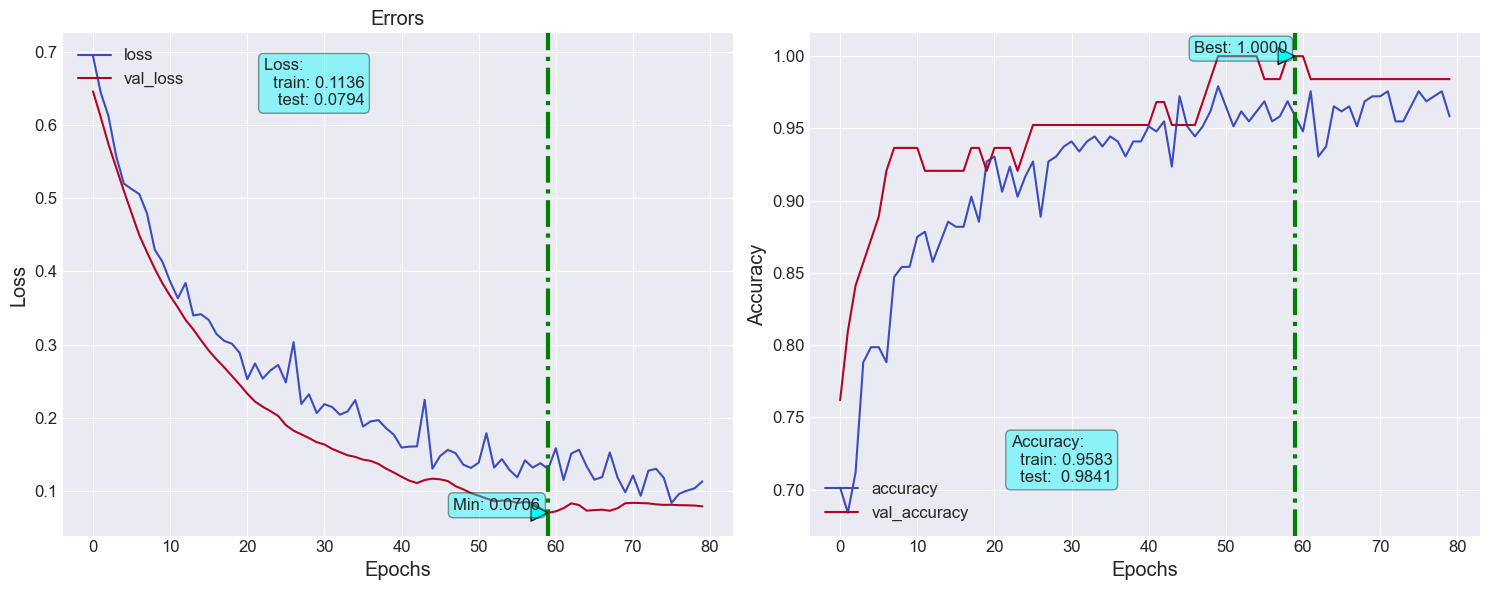

In [45]:
fn_plot_tf_hist(loss_df)